# CIFAR-10 ConvNet
This is my attempt at creating a ConvNet that can succesfully classify the CIFAR-10 dataset with good accuracy.

### Dataset Features
* 60,000 color images
* 32x32 image size
* 3 channels (RGB)
* 10 Classes (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck)
* 50,000 images in training set (5,000 per class)
* 10,000 images in testing set (1,000 per class)

### Adjustments to make it effective
* may require data augmentation
* may need deeper networks (and residual connections or inception modules)


## Goals

Create 2 models
* Baseline CNN (2-3 Conv Blocks, Pooling, 1-2 Dense Layers, ReLU activations) ~ > 70% accuracy
* Intermediate CNN (batch norm, data aug, deeper architecture, learning rate scheduling, stronger optimizers) ~ > 80% accuracy

### 1. Load the dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os

# Define transformations that will be applied as the data is loaded
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image or NumPy array to PyTorch Tensor,
                           # and scales pixel values from [0, 255] to [0.0, 1.0]
    transforms.Normalize(
        (0.5, 0.5, 0.5),  # Mean for R, G, B channels
        (0.5, 0.5, 0.5)   # std dev for R, G, B channels
    )
    # The (0.5, 0.5, 0.5) for mean and std effectively normalizes pixel values
    # from [0, 1] to [-1, 1]. This range is often preferred for model inputs.
    # More precise normalization values for CIFAR-10 are (0.4914, 0.4822, 0.4465) and (0.2471, 0.2435, 0.2616)
    # but (0.5, 0.5, 0.5) is a good common start.
])

# Load the CIFAR-10 Datasets
# torchvision.datasets.CIFAR10 will automatically download the dataset to the
# specified root directory if it's not already present
# Colab's default /content directory is a good place

print("Downloading CIFAR-10 training data...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',       # Directory to save the dataset
    train=True,          # Specify training set
    download=True,       # Download if not already downloaded
    transform=transform  # Apply the defined transformations
)
print("CIFAR-10 training data downloaded/loaded")

print("Downloading CIFAR-10 testing data...")
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
print("CIFAR-10 testing data downloaded/loaded")

# Create DataLoaders
# Provide an iterable over the dataset, handling batching, shuffling, etc
batch_size = 64
num_workers = os.cpu_count() # Number of subprocesses to use for data loading

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size,
    shuffle=False,
    num_workers=num_workers
)

print(f"\nTraining dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(f"Number of training batches (batch_size={batch_size}): {len(train_loader)}")
print(f"Number of test batches (batch_size={batch_size}): {len(test_loader)}")

CIFAR-10 training data downloaded/loaded
CIFAR-10 testing data downloaded/loaded

Training dataset size: 50000 images
Test dataset size: 10000 images
Number of training batches (batch_size=64): 782
Number of test batches (batch_size=64): 157


In [2]:
# Define transformations for training data including augmentations
# train_transform_augmented = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.2), # Randomly flip the image horizontally with 50% probability
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly change brightness, contrast, saturation, and hue
#     transforms.RandomRotation(degrees=5), # Randomly rotate the image by up to 15 degrees
#     transforms.ToTensor(), # Converts PIL Image or NumPy array to PyTorch Tensor
#     transforms.Normalize(
#         (0.5, 0.5, 0.5),  # Mean for R, G, B channels
#         (0.5, 0.5, 0.5)   # std dev for R, G, B channels
#     )
# ])

# New transoform using `transforms.TrivialAugmentWide`
train_transform_augmented = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),  # Mean for R, G, B channels
        (0.5, 0.5, 0.5)   # std dev for R, G, B channels
    )
])


# Load the CIFAR-10 Datasets with the new transforms
print("Downloading CIFAR-10 training data with augmentation...")
train_dataset_augmented = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_augmented  # Use augmented transform for training
)
print("CIFAR-10 training data downloaded/loaded with augmentation")

# Create DataLoaders with the new datasets
batch_size = 64
num_workers = os.cpu_count()

train_loader_augmented = torch.utils.data.DataLoader(
    train_dataset_augmented,
    batch_size,
    shuffle=True,
    num_workers=num_workers
)

print(f"\nTraining dataset size (augmented): {len(train_dataset_augmented)} images")
print(f"Test dataset size: {len(test_dataset)} images")
print(f"Number of training batches (batch_size={batch_size}): {len(train_loader_augmented)}")
print(f"Number of test batches (batch_size={batch_size}): {len(test_loader)}")

CIFAR-10 training data downloaded/loaded with augmentation

Training dataset size (augmented): 50000 images
Test dataset size: 10000 images
Number of training batches (batch_size=64): 782
Number of test batches (batch_size=64): 157


### Verify data loading and visualize a batch

In [3]:
# Get one batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print shapes
print(f"\nShape of one batch of images: {images.shape}") # Should be [batch_size, 3, 32, 32]
print(f"Shape of one batch of labels: {labels.shape}") # Should be [batch_size]


Shape of one batch of images: torch.Size([64, 3, 32, 32])
Shape of one batch of labels: torch.Size([64])


In [4]:
# Function to denormalize and show an image
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose from (C, H, W) to (H, W, C) for matplotlib
  plt.axis(False)
  plt.show()

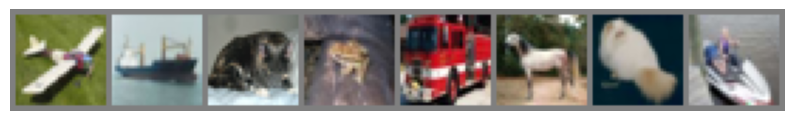

plane ship  cat   frog  truck horse cat   ship 


In [5]:
# Get random training images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
plt.figure(figsize=(10,2))
imshow(torchvision.utils.make_grid(images[:8])) # show first 8 images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
plt.show()


In [6]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## 1. Build baseline model

**Architecture**
* 2 Conv Blocks (Conv->ReLU->Conv->ReLU->MaxPool)
* Flatten
* 2 Dense Blocks (Linear->ReLU)

### 1.1 Create Model architecture

In [8]:
# Create ConvNet
class CIFAR10ConvNet1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, num_classes: int, dropout_rate=0.3):
    super(CIFAR10ConvNet1, self).__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    # Dummy forward pass to get size for Linear layer
    dummy_input_shape = (1, input_shape, 32, 32)
    dummy_input = torch.zeros(dummy_input_shape)

    with torch.inference_mode():
      dummy_ouput = self.conv_block2(self.conv_block1(dummy_input))

      # Flatten ouput to get shape
      flattened_output = dummy_ouput.view(dummy_ouput.size(0), -1)

      self.flattened_size = flattened_output.size(1)

    print(f"Calculated flattened size: {self.flattened_size}")

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.flattened_size, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=512, out_features=128),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=128, out_features=num_classes)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_1 = CIFAR10ConvNet1(input_shape=3, hidden_units=10, num_classes=10).to(device)

Calculated flattened size: 640


In [10]:
1

1

### 1.2 Set Loss Function / Optimizer / Evaluation Metrics

In [11]:
!pip install torchmetrics --quiet

In [12]:
import torchmetrics

accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()


### 1.3 Create Training and Testing Loops

In [13]:
def train_loop(model, dataloader, criterion, optimizer, accuracy_fn, device):
  """
  Complete training loop for one epoch.

  Inputs:
    model: PyTorch model to be trained
    dataloader: PyTorch DataLoader to loop through
    criterion: Loss function
    optimizer: PyTorch optimizer
    accuracy_fn: Accuracy metric
    device: PyTorch device
  """
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # raw logits

    # 2. Calculate the loss/accuracy
    loss = criterion(y_pred, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backprop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Print training loss and accuracy for each epoch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  # print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f}")
  return train_loss, train_acc

In [14]:
def test_loop(model, dataloader, criterion, accuracy_fn, device):
  """
  Complete testing loop for one epoch.

  Inputs:
    model: PyTorch model to be trained
    dataloader: PyTorch DataLoader to loop through
    criterion: Loss function
    accuracy_fn: Accuracy metric
    device: PyTorch device
  """

  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      test_loss += criterion(y_pred, y).item()
      test_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    # print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}")
    return test_loss, test_acc

In [15]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [16]:
def print_loss_accuracy(train_loss, train_accuracy, test_loss, test_accuracy, num_epochs):
  """Prints loss and accuracy curves"""
  epochs = range(1, num_epochs+1)

  # Move tensors to CPU before converting to NumPy for plotting
  train_loss_cpu = [loss.cpu() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
  train_accuracy_cpu = [acc.cpu() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy]
  test_loss_cpu = [loss.cpu() if isinstance(loss, torch.Tensor) else loss for loss in test_loss]
  test_accuracy_cpu = [acc.cpu() if isinstance(acc, torch.Tensor) else acc for acc in test_accuracy]

  plt.plot(epochs, train_loss_cpu, label="Train Loss")
  plt.plot(epochs, test_loss_cpu, label="Test Loss")
  plt.title("Loss vs. Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.plot(epochs, train_accuracy_cpu, label="Train Accuracy")
  plt.plot(epochs, test_accuracy_cpu, label="Test Accuracy")
  plt.title("Accuracy vs. Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

Calculated flattened size: 640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Epoch: 2
-------
Epoch: 3
-------
Epoch: 4
-------
Epoch: 5
-------
Epoch: 6
-------
Epoch: 7
-------
Epoch: 8
-------
Epoch: 9
-------
Epoch: 10
-------
Train time on cuda: 180.462 seconds


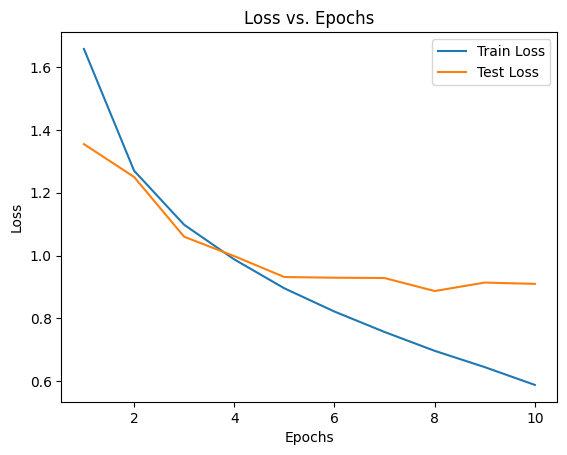

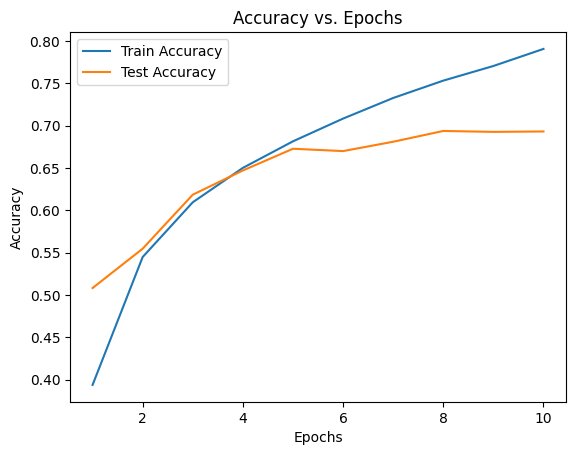

In [17]:
from tqdm.auto import tqdm
torch.manual_seed(42)

model_1 = CIFAR10ConvNet1(input_shape=3, hidden_units=10, num_classes=10, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

epochs = 10

TRAIN_LOSS = []
TRAIN_ACCURACY = []
TEST_LOSS = []
TEST_ACCURACY = []


# Measure time
train_time_start_on_cpu = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}\n-------")
  train_loss, train_acc = train_loop(model_1, train_loader, criterion, optimizer, accuracy_fn, device)
  test_loss, test_acc = test_loop(model_1, test_loader, criterion, accuracy_fn, device)
  TRAIN_LOSS.append(train_loss)
  TRAIN_ACCURACY.append(train_acc)
  TEST_LOSS.append(test_loss)
  TEST_ACCURACY.append(test_acc)


train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_cpu,
                                           train_time_end_on_cpu,
                                           device=device)

print_loss_accuracy(TRAIN_LOSS, TRAIN_ACCURACY, TEST_LOSS, TEST_ACCURACY, epochs)

Calculated flattened size: 640


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Epoch: 2
-------
Epoch: 3
-------
Epoch: 4
-------
Epoch: 5
-------
Epoch: 6
-------
Epoch: 7
-------
Epoch: 8
-------
Epoch: 9
-------
Epoch: 10
-------
Train time on cuda: 301.518 seconds


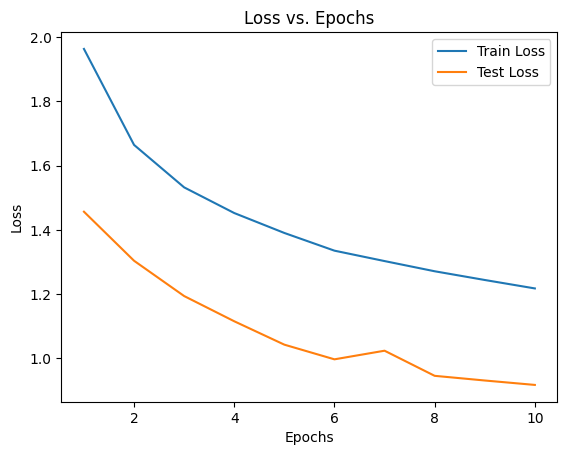

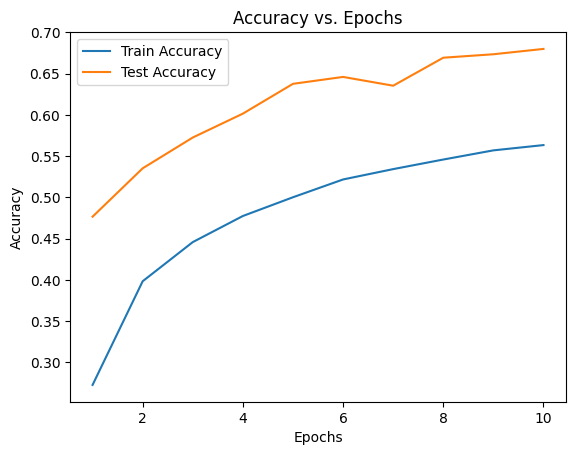

In [18]:
torch.manual_seed(42)

model_1_augmented = CIFAR10ConvNet1(input_shape=3, hidden_units=10, num_classes=10, dropout_rate=0.1).to(device)
epochs = 10
optimizer_augmented = torch.optim.Adam(params=model_1_augmented.parameters(), lr=0.001)
TRAIN_LOSS = []
TRAIN_ACCURACY = []
TEST_LOSS = []
TEST_ACCURACY = []

# Measure time
train_time_start_on_cpu = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}\n-------")
  train_loss, train_acc = train_loop(model_1_augmented, train_loader_augmented, criterion, optimizer_augmented, accuracy_fn, device)
  test_loss, test_acc = test_loop(model_1_augmented, test_loader, criterion, accuracy_fn, device)
  TRAIN_LOSS.append(train_loss)
  TRAIN_ACCURACY.append(train_acc)
  TEST_LOSS.append(test_loss)
  TEST_ACCURACY.append(test_acc)


train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_cpu,
                                           train_time_end_on_cpu,
                                           device=device)

print_loss_accuracy(TRAIN_LOSS, TRAIN_ACCURACY, TEST_LOSS, TEST_ACCURACY, epochs)

## 2. Build More Advanced Model

Explore tactics such as:
* Learning Rate Scheduling
* Different optimizers (SGD w/ Momentum, RMSprop)
* Add Batch Norm
* Increase model capacity (# filters or size of filters to learn complex features)
* Early Stopping

In [19]:
class CIFAR10ConvNet2(nn.Module):
  def __init__(self, input_shape: int, num_classes: int, dropout_rate=0.1):
    super(CIFAR10ConvNet2, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=32,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
      nn.Conv2d(in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Dummy forward pass to get size for Linear layer
    dummy_input_shape = (1, input_shape, 32, 32)
    dummy_input = torch.zeros(dummy_input_shape)

    with torch.inference_mode():
      dummy_ouput = self.conv_block3(self.conv_block2(self.conv_block1(dummy_input)))

      # Flatten ouput to get shape
      flattened_output = dummy_ouput.view(dummy_ouput.size(0), -1)

      self.flattened_size = flattened_output.size(1)

    print(f"Calculated flattened size: {self.flattened_size}")

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=self.flattened_size, out_features=1024),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=512, out_features=num_classes)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.classifier(x)
    return x



In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2 = CIFAR10ConvNet2(input_shape=3, num_classes=10, dropout_rate=0.1).to(device)

Calculated flattened size: 4096


In [21]:
# Print the model architecture
print(f"\n--- Model Architecture ---")
print(model_2)


--- Model Architecture ---
CIFAR10ConvNet2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.05, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, ep

### 2.1 Test on regular data

**Added Learning Rate scheduler to our training loop**

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_test_model(model, train_dataloader, test_dataloader, criterion, optimizer, accuracy_fn, device, epochs):
  train_loss = []
  train_acc = []
  test_loss = []
  test_acc = []

  # Initialize the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

  for epoch in tqdm(range(epochs)):
    # print(f"Epoch: {epoch+1}\n--------")
    train_loss_epoch, train_acc_epoch = train_loop(model, train_dataloader, criterion, optimizer, accuracy_fn, device)
    test_loss_epoch, test_acc_epoch = test_loop(model, test_dataloader, criterion, accuracy_fn, device)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    test_loss.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    # Step the scheduler based on the test loss
    scheduler.step(test_loss_epoch)


  print_loss_accuracy(train_loss, train_acc, test_loss, test_acc, epochs)

**Model 2 Base**

Calculated flattened size: 4096


  0%|          | 0/30 [00:00<?, ?it/s]

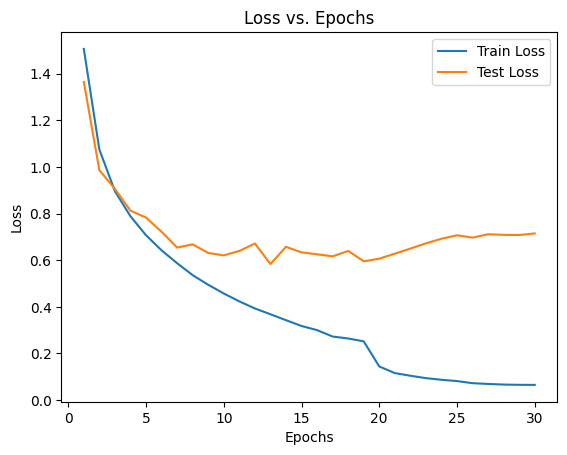

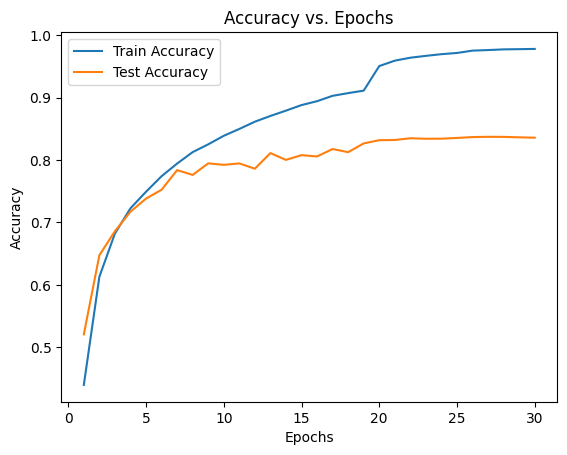

In [23]:
model_2 = CIFAR10ConvNet2(input_shape=3, num_classes=10, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

train_test_model(model_2, train_loader, test_loader, criterion, optimizer, accuracy_fn, device, 30)

**Model 2 with SGD optimizer and momentum**

Calculated flattened size: 4096


  0%|          | 0/30 [00:00<?, ?it/s]

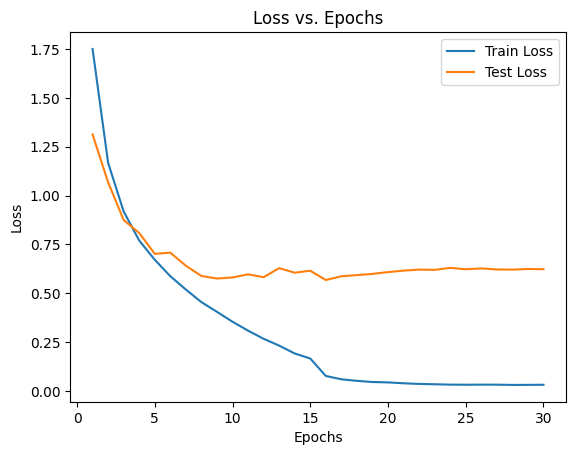

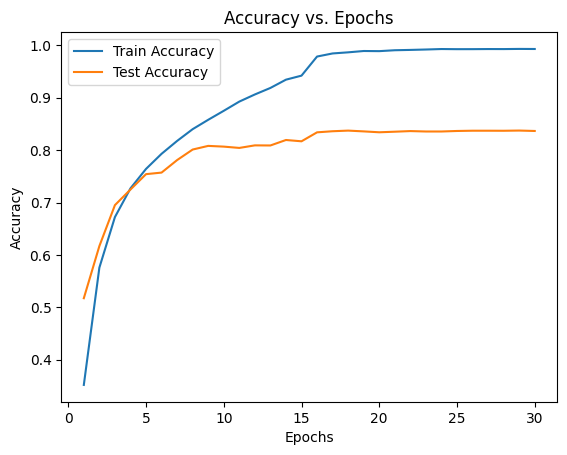

In [24]:
model_2 = CIFAR10ConvNet2(input_shape=3, num_classes=10, dropout_rate=0.1).to(device)
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001, momentum=0.9)
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

train_test_model(model_2, train_loader, test_loader, criterion, optimizer, accuracy_fn, device, 30)

**Model 2 using augmented training data**

Calculated flattened size: 4096


  0%|          | 0/30 [00:00<?, ?it/s]

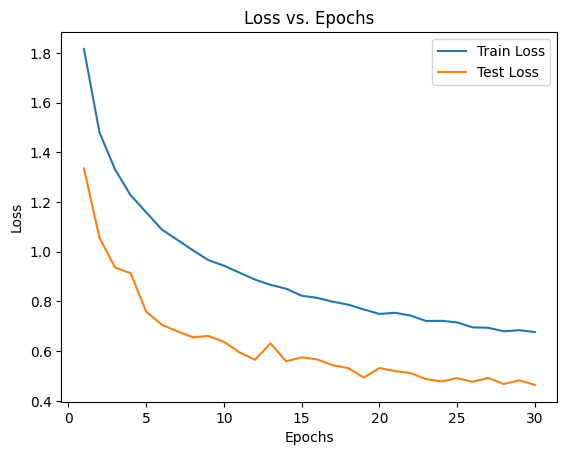

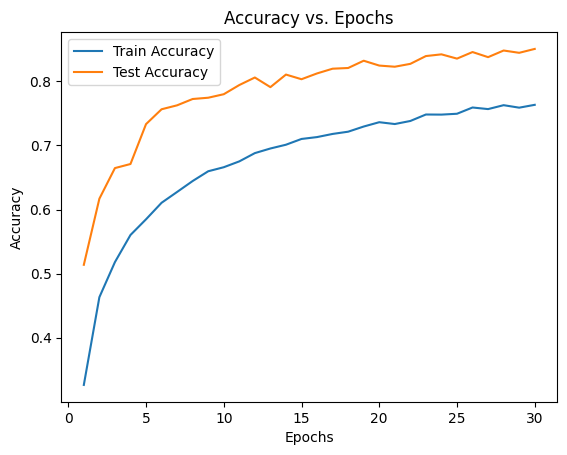

In [25]:
model_2_augmented = CIFAR10ConvNet2(input_shape=3, num_classes=10, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(params=model_2_augmented.parameters(), lr=0.001)
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

train_test_model(model_2_augmented, train_loader_augmented, test_loader, criterion, optimizer, accuracy_fn, device, 30)

In [26]:
# Save the state_dict of model_2
torch.save(model_2_augmented.state_dict(), 'cifar10_model_weights.pth')
print("cifar10_model_weights.pth saved successfully.")

cifar10_model_weights.pth saved successfully.


In [27]:
from google.colab import files

files.download('cifar10_model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>